<a href="https://colab.research.google.com/github/cse97/Udemy-courses/blob/main/1_RNN_LSTM_sinewave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import torch
import torch.nn as nn

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
# Create a sine wave dataset

x = torch.linspace(0,799,steps=800)
y = torch.sin(x*2*3.1416/40)  ## 40 points per full cycle

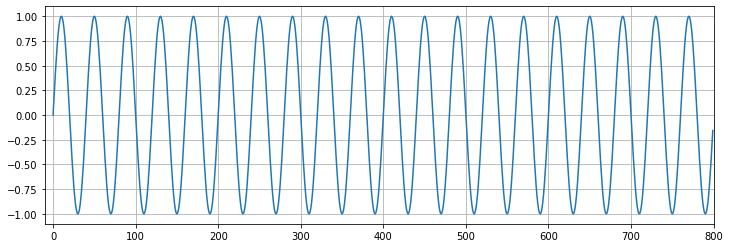

In [97]:
# Plot the data points

plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(y.numpy());

In [98]:
# Create train and test set using first 760 samples from the data series as training sequence and last 40 for testing

test_size = 40

train_set = y[:-test_size]
test_set = y[-test_size:]

In [99]:
# When working with LSTM models, we start by dividing the training sequence into a series of overlapping "windows".
# Windows overlap, so the first tuple might contain ([x_1,..,x_5],[x_6]), the second would have ([x_2,..,x_6],[x_7]), etc.
# Here ws is the width of the window. Due to the overlap, we'll have a total number of (seq, label) tuples equal to len(series)-ws

def input_data(seq,ws):  ## ws is the window size
    out = []  ##([0,1,2,3],[4]),([1,2,3,4],[5]),...
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [100]:
# To train on our sine wave data

window_size = 40

# Create the training dataset of sequence/label tuples:

train_data = input_data(train_set,window_size)

In [101]:
len(train_data)      

# 0-799 = 800
# 800-40 = 760
# 760-40 = 740

720

In [102]:
# Display the first (seq/label) tuple in train_data

torch.set_printoptions(sci_mode=False)
train_data[0]

(tensor([     0.0000,      0.1564,      0.3090,      0.4540,      0.5878,
              0.7071,      0.8090,      0.8910,      0.9511,      0.9877,
              1.0000,      0.9877,      0.9511,      0.8910,      0.8090,
              0.7071,      0.5878,      0.4540,      0.3090,      0.1564,
             -0.0000,     -0.1564,     -0.3090,     -0.4540,     -0.5878,
             -0.7071,     -0.8090,     -0.8910,     -0.9511,     -0.9877,
             -1.0000,     -0.9877,     -0.9511,     -0.8910,     -0.8090,
             -0.7071,     -0.5878,     -0.4540,     -0.3090,     -0.1564]),
 tensor([    0.0000]))

In [103]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,out_size)
        
        # Initialize hidden state h0 and cell state c0:
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))

        # [1,2,3][4] ---> [1,2,3,4 ---> 4]
        return pred[-1]   ## we only care about the last prediction

In [104]:
# Instantiate the model, define loss & optimization functions

torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [105]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [106]:
# To find no. of parameters

for p in model.parameters():
  print(p.numel())

200
10000
200
200
50
1


`Take the last known window, predict the next value, then append the predicted value to the sequence and run a new prediction on a window that includes the value we've just predicted.`

Epoch: 0 Loss: 0.09212876856327057
Loss on test predictions: 0.6071590781211853


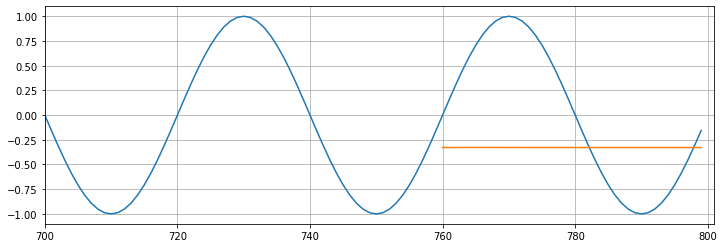

Epoch: 1 Loss: 0.06506765633821487
Loss on test predictions: 0.5650987029075623


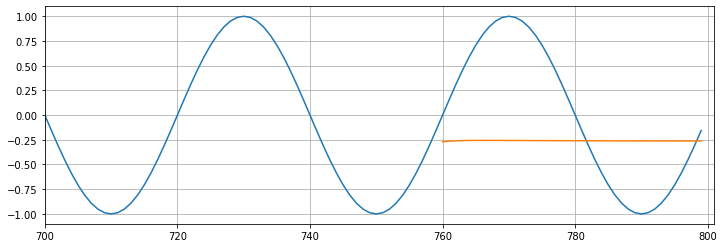

Epoch: 2 Loss: 0.04198050498962402
Loss on test predictions: 0.5199717283248901


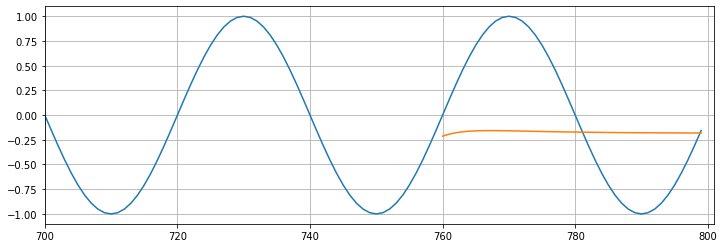

Epoch: 3 Loss: 0.017842771485447884
Loss on test predictions: 0.42209967970848083


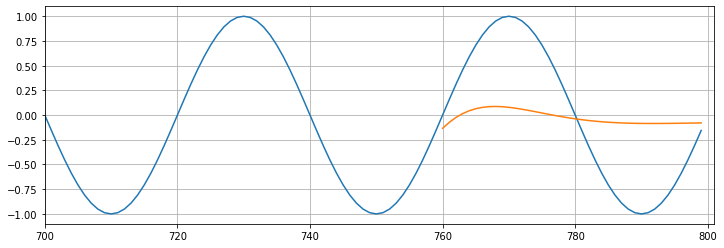

Epoch: 4 Loss: 0.0028870997484773397
Loss on test predictions: 0.16624124348163605


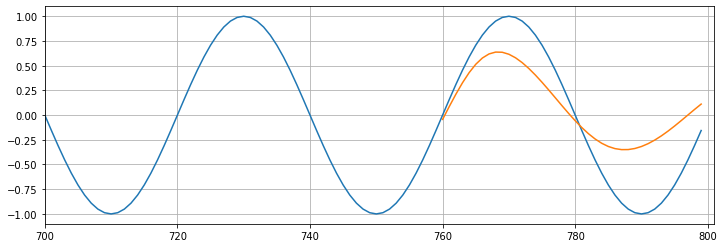

Epoch: 5 Loss: 0.00032007417757995427
Loss on test predictions: 0.030554374679923058


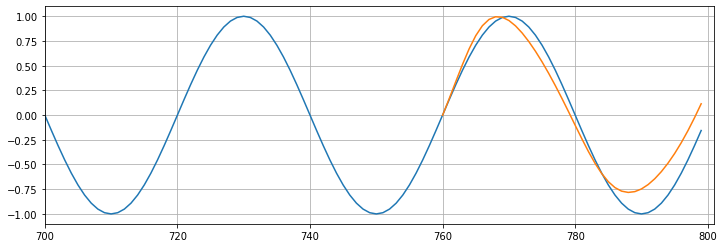

Epoch: 6 Loss: 0.00012969069939572364
Loss on test predictions: 0.01499019842594862


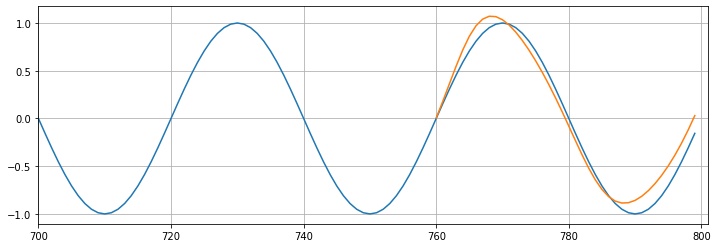

Epoch: 7 Loss: 0.00012006700853817165
Loss on test predictions: 0.011856636963784695


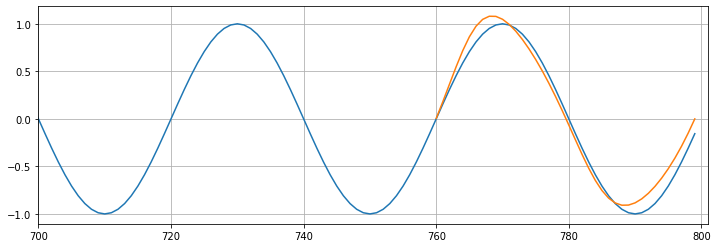

Epoch: 8 Loss: 0.00012655690079554915
Loss on test predictions: 0.01016381848603487


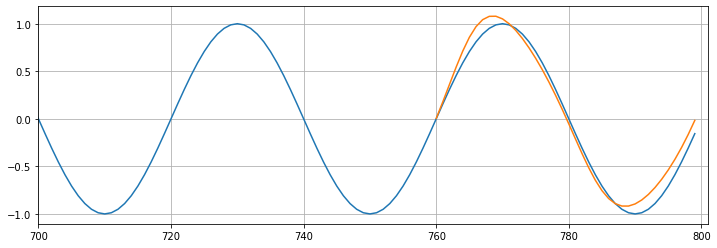

Epoch: 9 Loss: 0.00013195440988056362
Loss on test predictions: 0.008897608146071434


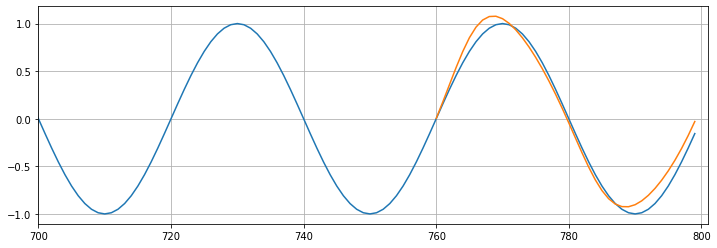

In [107]:
# Train and simultaneously evaluate the model

epochs = 10
future = 40

for i in range(epochs):
    
    # tuple-unpack the train_data set
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {i} Loss: {loss.item()}')


   # MAKE PREDICTIONS
   # start with a list of the last 10 training records
    preds = train_set[-window_size:].tolist()

    for f in range(future):  
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
            
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f'Loss on test predictions: {loss}') 


   # Plot from point 700 to the end

    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()

In [108]:
# Train the model using entire dataset. Then we'll predict what the next 40 points should be.

epochs = 10
window_size = 40
future = 40

# Create the full set of sequence/label tuples:
all_data = input_data(y,window_size)
len(all_data)  ## 800-40 = 760

760

Epoch: 0 Loss: 0.00013452998246066272


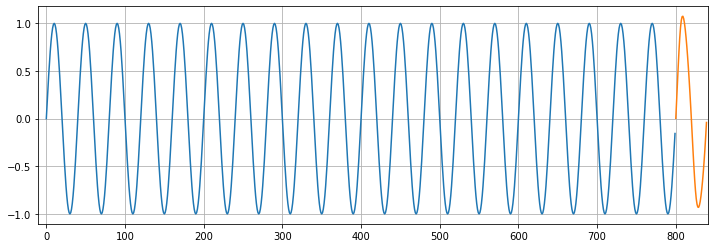

Epoch: 1 Loss: 0.00013443011266645044


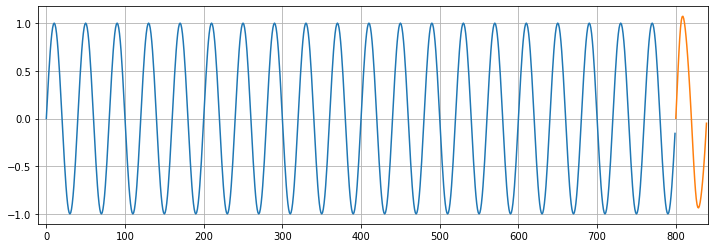

Epoch: 2 Loss: 0.00013231823686510324


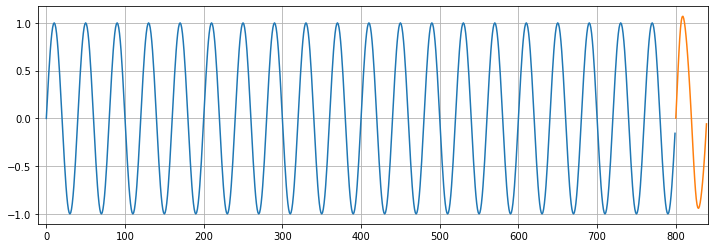

Epoch: 3 Loss: 0.0001287959166802466


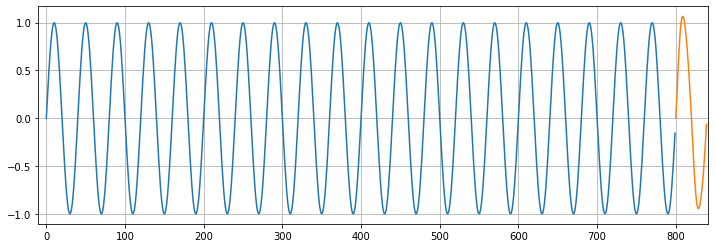

Epoch: 4 Loss: 0.00012434215750545263


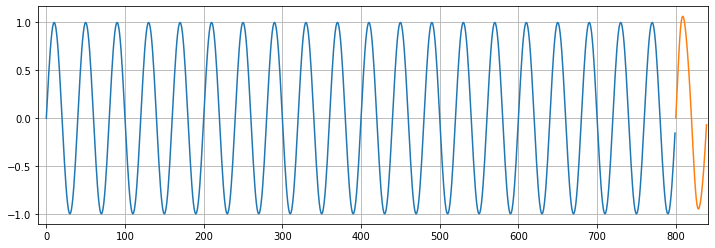

Epoch: 5 Loss: 0.00011931286280741915


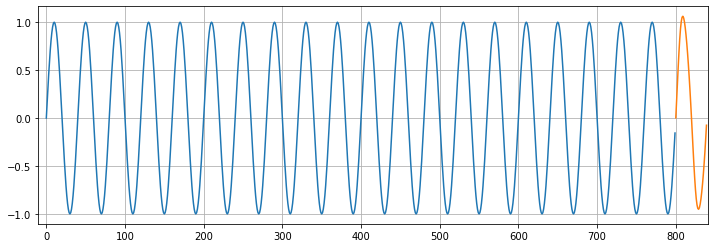

Epoch: 6 Loss: 0.00011398040078347549


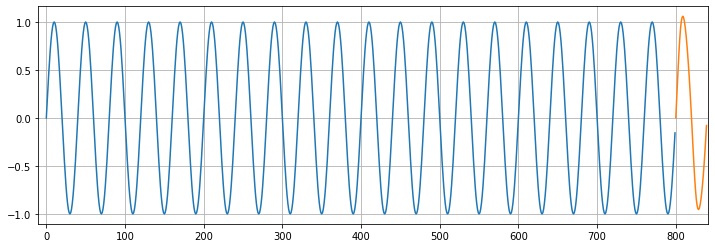

Epoch: 7 Loss: 0.00010853995627257973


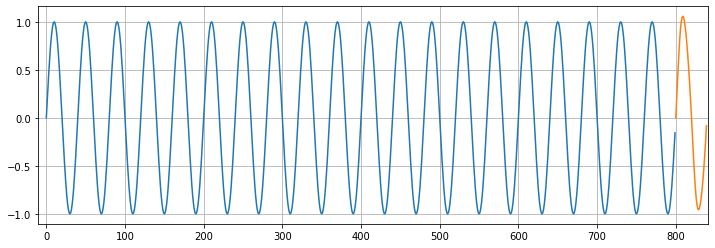

Epoch: 8 Loss: 0.00010312719678040594


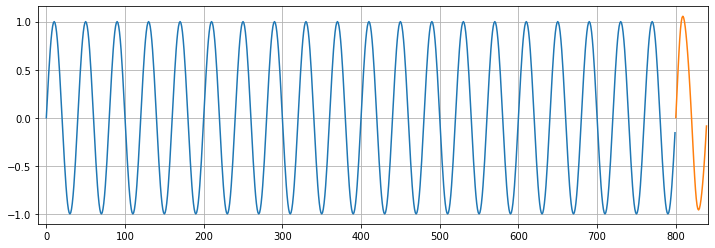

Epoch: 9 Loss: 9.784226858755574e-05


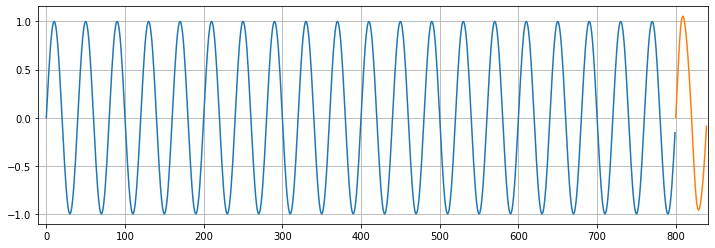

1.1595886071523032


In [109]:
import time
start_time = time.time()

for i in range(epochs):
    
    # tuple-unpack the entire set of data
    for seq, y_train in all_data:  ## in place of train_data we use all_data 
       
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {i} Loss: {loss.item()}')

    # MAKE FUTURE PREDICTIONS

    preds = y[-window_size:].tolist()

    for i in range(future):  
      seq = torch.FloatTensor(preds[-window_size:])
      with torch.no_grad():
        # Reset the hidden parameters
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

    # Plot the forecast result

    plt.figure(figsize=(12,4))
    plt.xlim(-10,841)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(800,800+future),preds[window_size:])
    plt.show()

total_time = time.time() - start_time
print(total_time/60)